Configure notebook...

In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/work/git/isaac-demo/ipynb'

Imports

In [2]:
from pathlib import Path
import datetime
import pandas as pd
from IPython.display import IFrame, HTML, Markdown, Image, display

Define benchmark

In [3]:
OUT_DIR_BASE = "../out"
BENCH = "nettle-aes"
DATE = "latest"

Lookup directories

In [4]:
BENCH_DIR = Path(OUT_DIR_BASE) / BENCH
print("BENCH_DIR", BENCH_DIR)
assert BENCH_DIR.is_dir()
if DATE == "latest":
    dates = [f for f in BENCH_DIR.iterdir() if f.is_dir()]
    assert len(dates) > 0
    if len(dates) == 1:
        DATE = dates[0].name
    else:
        sorted_dates = sorted(dates, key=lambda x: datetime.datetime.strptime(x.name, "%Y%m%dT%H%M%S"))
        DATE = sorted_dates[-1].name
DATE_DIR = BENCH_DIR / DATE
assert DATE_DIR.is_dir()

print(f"Picked date: {DATE}")
print(f"Directory: {DATE_DIR}")

RUN = DATE_DIR / "run"
SESS = DATE_DIR / "sess"
WORK = DATE_DIR / "work"

PLOTS_DIR = SESS / "plots"

BENCH_DIR ../out/nettle-aes
Picked date: 20241202T160512
Directory: ../out/nettle-aes/20241202T160512


Check baseline benchmark (ISS)

In [5]:
REPORT = RUN / "report.csv"

COLS = ["Model", "Run Instructions", "Total ROM", "Total RAM"]
pd.read_csv(REPORT)[COLS]

,Model,Run Instructions,Total ROM,Total RAM
0,nettle-aes,3573210,56672,4216


## Trace Analysis

### Identification of Bottlenecks

Per basic-block

In [6]:
IFrame(PLOTS_DIR / "runtime_per_llvm_bb.jpg", 700, 350)

Per function

In [7]:
IFrame(PLOTS_DIR / "runtime_per_func.jpg", 700, 350)

Per library

In [8]:
IFrame(PLOTS_DIR / "runtime_per_library.jpg", 700, 350)

Per object

In [9]:
IFrame(PLOTS_DIR / "runtime_per_object.jpg", 700, 350)

### Analyze instruction types

Per major opcode

In [10]:
IFrame(PLOTS_DIR / "runtime_per_opcode.jpg", 700, 350)

Per instruction name

In [11]:
IFrame(PLOTS_DIR / "runtime_per_instr.jpg", 700, 350)

### Choose BBs for ISE identification

In [12]:
CHOICES = SESS / "table" / "choices.pkl"

choices_df = pd.read_pickle(CHOICES)
choices_df

,func_name,bb_name,rel_weight,num_instrs,freq
0,_nettle_aes_decrypt,%bb.6,0.39303,87.0,16224.0
1,_nettle_aes_encrypt,%bb.6,0.39303,87.0,16224.0


## Identification of ISE candidates

### Per Func+BB

Filtered candidates

,Label,Count
0,Iso,2453
1,Filtered (I/O),582
2,Filtered (Mem),29
3,Selected,13
4,Filtered (Operands),2
5,Filtered (Weights),2


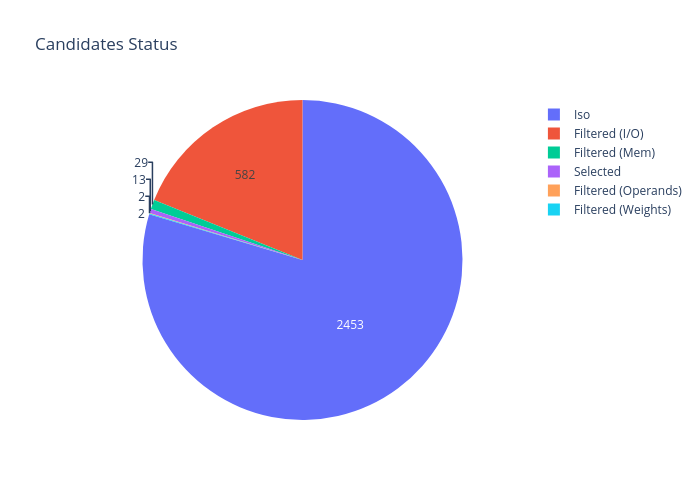

,Label,Count
0,Iso,2554
1,Filtered (I/O),481
2,Filtered (Mem),29
3,Selected,13
4,Filtered (Operands),2
5,Filtered (Weights),2


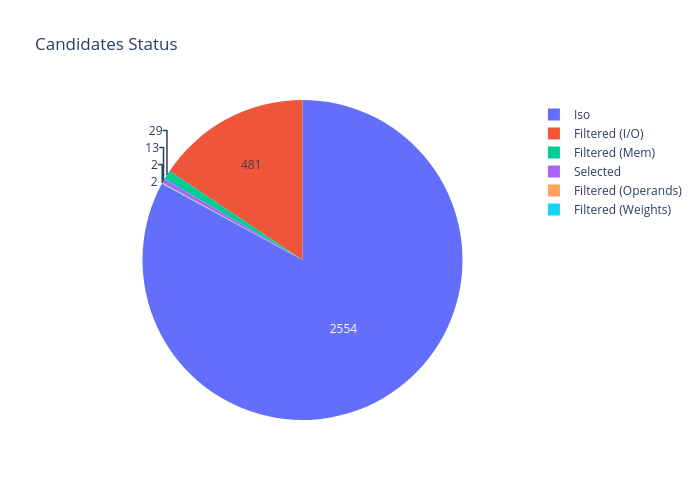

In [13]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    pie_csv = func_bb_dir / "pie.csv"
    pie_img = func_bb_dir / "pie.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie_csv))
    display(Image(pie_img))

Generated variations 

,Label,Count
0,Unknown,3081


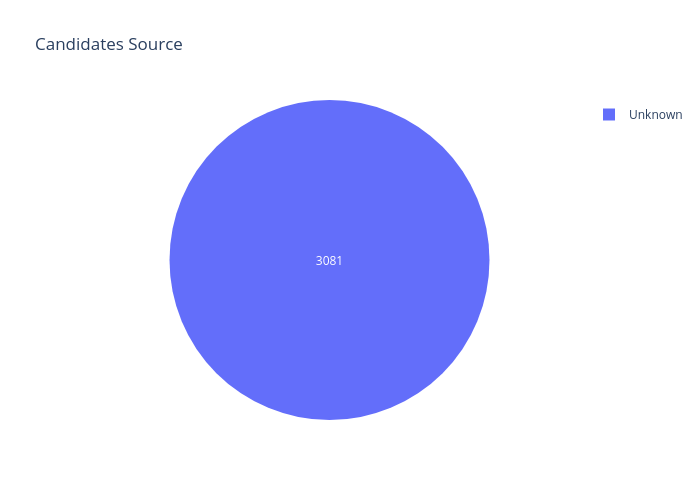

,Label,Count
0,Unknown,3081


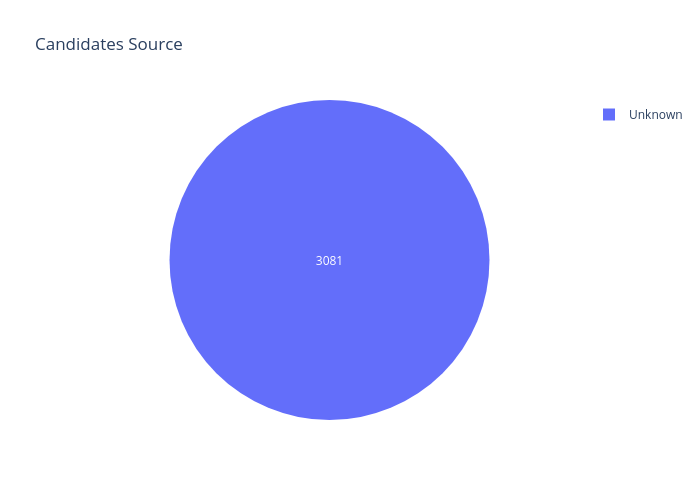

In [14]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: check suffix?
    pie2_csv = func_bb_dir / "pie2.csv"
    pie2_img = func_bb_dir / "pie2.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie2_csv))
    display(Image(pie2_img))

Profile

In [15]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    times_csv = func_bb_dir / "times.csv"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(times_csv))

,Secs,Secs (rel.)
0,0.000090,0.000006
1,0.000168,0.000012
2,0.005047,0.000365
3,0.005802,0.000419
4,0.214815,0.015528
5,2.736835,0.197835
6,0.089663,0.006481
7,0.477722,0.034533
8,0.047734,0.003450
9,2.507141,0.181231


,Secs,Secs (rel.)
0,0.000088,0.000006
1,0.000173,0.000013
2,0.005025,0.000363
3,0.005307,0.000383
4,0.175848,0.012705
5,2.778149,0.200721
6,0.089254,0.006449
7,0.457916,0.033084
8,0.043708,0.003158
9,2.518037,0.181928


### Combined results

Pairwise overlaps

In [16]:
overlaps_file = WORK / "overlaps.csv"
pd.read_csv(overlaps_file)

,x,y,nodes,size
0,0,1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}",13


Venn diagram

In [17]:
venn_file = WORK / "venn.jpg"
if len(choices_df) in [2, 3]:
    if venn_file.is_file():
        display(IFrame(venn_file, 700, 350))

Sankey diagram (duplicates vs. unqiue instructions)

In [18]:
sankey_file =  WORK / "sankey.md"
with open(sankey_file, "r") as f:
    content = f.read()
display(Markdown(content))


```mermaid
---
config:
  sankey:
    showValues: true
---
sankey-beta

%% source,target,value
Set0,Merged,13
Set1,Merged,13
Merged,Duplicates,13
Merged,Unique,13
Unique,Topk,13

```


### Analyse combined index

In [70]:
combined_index_yaml = WORK / "combined_index.yml"
names_csv = WORK / "names.csv"
names_df = pd.read_csv(names_csv)
num_candidates = len(names_df)
names_df

,instr,instr_lower
0,CUSTOM0,custom0
1,CUSTOM1,custom1
2,CUSTOM2,custom2
3,CUSTOM3,custom3
4,CUSTOM4,custom4
5,CUSTOM5,custom5
6,CUSTOM6,custom6
7,CUSTOM7,custom7
8,CUSTOM8,custom8
9,CUSTOM9,custom9


Analyze Encoding Footprint

In [20]:
import sys
sys.path.append("../scripts/")
from analyze_encoding import collect_weights, get_enc_weights_df, plot_enc_pie_multi, get_enc_score_df

In [21]:
enc_size = 32

total_weight, weight_per_instr, footprint_per_instr, rest_weight, bits_per_instr = collect_weights(combined_index_data, enc_size=enc_size)
enc_weights_df = get_enc_weights_df(total_weight, weight_per_instr, bits_per_instr, footprint_per_instr)
# enc_weights_df
enc_score_df = get_enc_score_df(enc_weights_df)
enc_score_df

,instr,bits,footprint,weight,enc_score
0,CUSTOM0,15.0,0.6,0.000244,0.999756
1,CUSTOM1,15.0,0.6,0.000244,0.999756
2,CUSTOM2,15.0,0.6,0.000244,0.999756
3,CUSTOM3,10.0,0.4,0.000008,0.999992
4,CUSTOM4,10.0,0.4,0.000008,0.999992
5,CUSTOM5,10.0,0.4,0.000008,0.999992
6,CUSTOM6,10.0,0.4,0.000008,0.999992
7,CUSTOM7,15.0,0.6,0.000244,0.999756
8,CUSTOM8,15.0,0.6,0.000244,0.999756
9,CUSTOM9,15.0,0.6,0.000244,0.999756


In [22]:
total_weight

0.002227783203125

Pie chart for enc weights (total and per custom instruction)

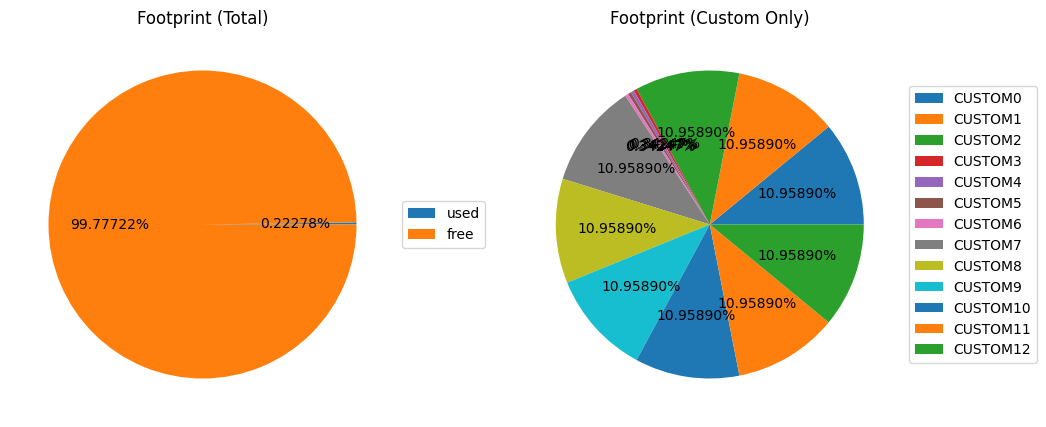

In [23]:
_ = plot_enc_pie_multi(weight_per_instr, rest_weight=rest_weight)

Number of candidates

In [24]:
num_candidates

13

## Generation of Instruction Set

Investigate generated Flat (unfused) CoreDSL per instruction

In [25]:
gen_dir = WORK / "gen"
for file in gen_dir.glob("*.flat"):
    display(HTML(f"<h3>File: {file.name}</h2>"))
    with open(file, "r") as f:
        code = f.read()
    display(Markdown(f"```c\n{code}\n```"""))

```c
// DateTime: 20241203T131654, Sub: 14, Name: name14, Inputs: 3, Outputs: 1
unsigned<32> rs3_val=X[rs3];
unsigned<32> rs1_val=X[rs1];
unsigned<32> rd_val=X[rd];
unsigned<32> outp0=(unsigned<32>)(XOR((unsigned<32>)(XOR(rs1_val,rd_val)),rs3_val));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131654, Sub: 15, Name: name15, Inputs: 3, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> rd_val=X[rd];
unsigned<32> outp0=(unsigned<32>)(XOR((unsigned<32>)(XOR(rs1_val,rs2_val)),rd_val));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 18, Name: name18, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(6))),(1020)));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 2, Name: name2, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(6))),(1020)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 8, Name: name8, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(SLLI((unsigned<32>)(ANDI(rs2_val,(255))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 21, Name: name21, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(SLLI((unsigned<32>)(SRLI(rs2_val,(24))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 26, Name: name26, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs2_val,(14))),(1020)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 4, Name: name4, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(6))),(1020)));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131654, Sub: 13, Name: name13, Inputs: 3, Outputs: 1
unsigned<32> rs3_val=X[rs3];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rd_val=X[rd];
unsigned<32> outp0=(unsigned<32>)(XOR((unsigned<32>)(XOR(rd_val,rs2_val)),rs3_val));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 10, Name: name10, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(SLLI((unsigned<32>)(ANDI(rs1_val,(255))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 0, Name: name0, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(ANDI(rs1_val,(1020)))));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 16, Name: name16, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(6))),(1020)))));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 19, Name: name19, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(SRLI(rs1_val,(24))),(2)));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 20, Name: name20, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ANDI(rs1_val,(255))),(2)));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 17, Name: name17, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(14))),(1020)));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 9, Name: name9, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(SLLI((unsigned<32>)(SRLI(rs1_val,(24))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 6, Name: name6, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ANDI(rs1_val,(255))),(2)));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 5, Name: name5, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(SRLI(rs1_val,(24))),(2)));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 12, Name: name12, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs2_val,(14))),(1020)))));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 24, Name: name24, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(SLLI((unsigned<32>)(ANDI(rs1_val,(255))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 23, Name: name23, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(SLLI((unsigned<32>)(SRLI(rs1_val,(24))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 3, Name: name3, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(14))),(1020)));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 25, Name: name25, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(14))),(1020)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 1, Name: name1, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(SLLI(rs1_val,(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 7, Name: name7, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(SLLI((unsigned<32>)(SRLI(rs2_val,(24))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241203T131633, Sub: 22, Name: name22, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(SLLI((unsigned<32>)(ANDI(rs2_val,(255))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20241210T120432, Sub: 11, Name: name11, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(ANDI((unsigned<32>)(SRLI(rs1_val,(14))),(1020)))));
X[rd]=outp0;
```

CoreDSL Set with automatic encoding

In [26]:
set_file = WORK / "XIsaac.core_desc"

with open(set_file, "r") as f:
    code = f.read()

display(Markdown(f"```c\n{code}\n```"""))

```c
import "/work/git/isaac-demo/etiss_arch_riscv/rv_base/RVI.core_desc"

InstructionSet XIsaac extends RV32I {
    instructions {
        CUSTOM0 {
            encoding: 7'b0000000 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom0", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) & (unsigned<32>)((1020)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM1 {
            encoding: 7'b0000001 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom1", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) << (unsigned<32>)((2)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM2 {
            encoding: 7'b0000010 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom2", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((6)))))) & (unsigned<32>)((1020)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM3 {
            encoding: 7'b0000011 :: 5'b00000 :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom3", "{name(rd)}, {name(rs1)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((14)))))) & (unsigned<32>)((1020)))));
                X[rd] = outp0;
            }
        }
        CUSTOM4 {
            encoding: 7'b0000100 :: 5'b00000 :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom4", "{name(rd)}, {name(rs1)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((6)))))) & (unsigned<32>)((1020)))));
                X[rd] = outp0;
            }
        }
        CUSTOM5 {
            encoding: 7'b0000101 :: 5'b00000 :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom5", "{name(rd)}, {name(rs1)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((24)))))) << (unsigned<32>)((2)))));
                X[rd] = outp0;
            }
        }
        CUSTOM6 {
            encoding: 7'b0000110 :: 5'b00000 :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom6", "{name(rd)}, {name(rs1)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) & (unsigned<32>)((255)))))) << (unsigned<32>)((2)))));
                X[rd] = outp0;
            }
        }
        CUSTOM7 {
            encoding: 7'b0000111 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom7", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs2_val) >> (unsigned<32>)((24)))))) << (unsigned<32>)((2)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM8 {
            encoding: 7'b0001000 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom8", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs2_val) & (unsigned<32>)((255)))))) << (unsigned<32>)((2)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM9 {
            encoding: 7'b0001001 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom9", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((24)))))) << (unsigned<32>)((2)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM10 {
            encoding: 7'b0001010 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom10", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) & (unsigned<32>)((255)))))) << (unsigned<32>)((2)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM11 {
            encoding: 7'b0001011 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom11", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) >> (unsigned<32>)((14)))))) & (unsigned<32>)((1020)))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM12 {
            encoding: 7'b0001100 :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom12", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs1_val) + (signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs2_val) >> (unsigned<32>)((14)))))) & (unsigned<32>)((1020)))))))));
                X[rd] = outp0;
            }
        }
    }
}


```

## LLVM Retargeting

## Seal5 Reports

In [27]:
reports_dir = WORK / "docker" / "seal5_reports"

### Properties

In [28]:
properties_csv = reports_dir / "properties.csv"
pd.read_csv(properties_csv)

,model,set,xlen,is_rv32,is_rv64,instr,enc_size,is_compressed,enc_format,opcode,...,is_siso,is_simo,has_imm_leaf,has_side_effects,may_load,may_store,is_terminator,is_branch,uses_custom_reg,defs_custom_reg
0,XIsaac,XIsaac,32,True,False,CUSTOM0,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
1,XIsaac,XIsaac,32,True,False,CUSTOM1,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
2,XIsaac,XIsaac,32,True,False,CUSTOM2,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
3,XIsaac,XIsaac,32,True,False,CUSTOM3,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
4,XIsaac,XIsaac,32,True,False,CUSTOM4,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
5,XIsaac,XIsaac,32,True,False,CUSTOM5,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
6,XIsaac,XIsaac,32,True,False,CUSTOM6,32,False,r-type (unop),custom-3,...,True,False,False,False,False,False,False,False,False,False
7,XIsaac,XIsaac,32,True,False,CUSTOM7,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
8,XIsaac,XIsaac,32,True,False,CUSTOM8,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
9,XIsaac,XIsaac,32,True,False,CUSTOM9,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False


### Stage Times

In [65]:
stage_times_csv = reports_dir / "stage_times.csv"
pd.read_csv(stage_times_csv)[["stage", "time_s"]].dropna()

,stage,time_s
0,setup,38.525705
1,patch,18.895561
2,build,873.806360
3,transform,1.505749
4,generate,1.470800
5,patch,11.247951
6,build,59.737247
7,build,7.439931
8,build,7.460552
9,generate,2.102515


### Passes

In [30]:
seal5_status_csv = reports_dir / "status.csv"
seal5_status_compact_csv = reports_dir / "status_compact.csv"
seal5_status_df = pd.read_csv(seal5_status_csv)
seal5_status_compact_df = pd.read_csv(seal5_status_compact_csv)
seal5_status_compact_df

,model,set,xlen,instr,n_success,n_skipped,n_failed,n_total,status
0,XIsaac,XIsaac,32,CUSTOM0,12,0,0,12,good
1,XIsaac,XIsaac,32,CUSTOM1,12,0,0,12,good
2,XIsaac,XIsaac,32,CUSTOM2,12,0,0,12,good
3,XIsaac,XIsaac,32,CUSTOM3,12,0,0,12,good
4,XIsaac,XIsaac,32,CUSTOM4,12,0,0,12,good
5,XIsaac,XIsaac,32,CUSTOM5,12,0,0,12,good
6,XIsaac,XIsaac,32,CUSTOM6,12,0,0,12,good
7,XIsaac,XIsaac,32,CUSTOM7,12,0,0,12,good
8,XIsaac,XIsaac,32,CUSTOM8,12,0,0,12,good
9,XIsaac,XIsaac,32,CUSTOM9,12,0,0,12,good


### Test Results/Coverage

In [31]:
# test_coverage_compact_csv = reports_dir / "test_coverage_compact.csv"
# pd.read_csv(test_coverage_compact_csv)

In [32]:
# test_results_compact_csv = reports_dir / "test_results_compact.csv"
# pd.read_csv(test_results_compact_csv)

### Changed Files/Lines

In [33]:
seal5_diff_csv = reports_dir / "diff.csv"
seal5_diff_df = pd.read_csv(seal5_diff_csv)
seal5_diff_df

,phase,n_files_changed,n_insertions,n_deletions
0,PHASE_0,29,4402,5
1,PHASE_1,3,15,0
2,PHASE_2,15,570,0
3,PHASE_3,0,0,0
4,PHASE_4,14,143,0
5,PHASE_5,0,0,0
6,*,57,5130,5


In [34]:
seal5_diff_csv

PosixPath('../out/nettle-aes/20241202T160512/work/docker/seal5_reports/diff.csv')

seal5_phases ['PHASE_1', 'PHASE_2', 'PHASE_3', 'PHASE_4', 'PHASE_5']


,step,n_files_changed,n_insertions,n_deletions
0,seal5,32,728,0
1,etiss,1,986,0


### Seal5 Score

In [64]:
seal5_score_data = []
seal5_pattern_gen_status_df = seal5_status_df[seal5_status_df["pass"] == "generate_passes.pattern_gen.behav_to_pat"][["instr", "status"]]
seal5_passes_status_df = seal5_status_compact_df[["instr", "status"]]
# print("seal5_passes_status_df", seal5_passes_status_df)
for instr_name in seal5_status_df["instr"].unique():
    # print("instr_name", instr_name)
    passes_status = seal5_passes_status_df[seal5_passes_status_df["instr"] == instr_name]
    assert len(passes_status) == 1
    passes_status = passes_status["status"].iloc[0]
    passes_score = 1.0 if passes_status == "good" else (0.5 if passes_status == "ok" else 0.0)
    
    pattern_gen_status = seal5_pattern_gen_status_df[seal5_pattern_gen_status_df["instr"] == instr_name]
    assert len(pattern_gen_status) == 1
    pattern_gen_status = pattern_gen_status["status"].iloc[0]
    # print("pattern_gen_status", pattern_gen_status)
    pattern_gen_score = 1.0 if pattern_gen_status == "success" else -1.0
    # print("pattern_gen_score", pattern_gen_score)
    
    new = {"instr": instr_name, "pattern_gen_score": pattern_gen_score, "passes_score": passes_score}
    seal5_score_data.append(new)
    
def calc_seal5_score(x):
    return x.min()

seal5_score_df = pd.DataFrame(seal5_score_data)
seal5_score_df["seal5_score"] =  seal5_score_df[["pattern_gen_score", "passes_score"]].apply(calc_seal5_score, axis=1)
seal5_score_df
# TODO: write to file

,instr,pattern_gen_score,passes_score,seal5_score
0,CUSTOM0,1.0,1.0,1.0
1,CUSTOM1,1.0,1.0,1.0
2,CUSTOM2,1.0,1.0,1.0
3,CUSTOM3,1.0,1.0,1.0
4,CUSTOM4,1.0,1.0,1.0
5,CUSTOM5,1.0,1.0,1.0
6,CUSTOM6,1.0,1.0,1.0
7,CUSTOM7,1.0,1.0,1.0
8,CUSTOM8,1.0,1.0,1.0
9,CUSTOM9,1.0,1.0,1.0


## ISS Evaluation

In [47]:
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,nettle-aes,rv32imfd,3573210,1.000000
1,nettle-aes,rv32imfd_xisaac,2654136,0.742788


In [48]:
#TEMP
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,nettle-aes,rv32imfd,3573210,1.000000
1,nettle-aes,rv32imfd_xisaac,2654136,0.742788


In [49]:
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,nettle-aes,rv32imfd,15956,2744,6140,1.000000
1,nettle-aes,rv32imfd_xisaac,15840,2744,6024,0.981107


In [50]:
# temp
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,nettle-aes,rv32imfd,15956,2744,6140,1.000000
1,nettle-aes,rv32imfd_xisaac,15840,2744,6024,0.981107


### MLonMCU Score (Set)

In [51]:
assert len(bench_compare_df) == 2
run_instrs_rel = bench_compare_df["Run Instructions (rel.)"].iloc[-1]
assert len(bench_compare_mem_df) == 2
rom_code_rel = bench_compare_mem_df["ROM code (rel.)"].iloc[-1]

run_instrs_score = 1.0/run_instrs_rel-1
rom_code_score = 1.0/rom_code_rel-1

# TODO: cycles!

RUN_INSTR_WEIGHT_POS = 2
ROM_CODE_WEIGHT_POS = 1
RUN_INSTR_WEIGTH_NEG = 10
ROM_CODE_WEIGHT_NEG = 2

mlonmcu_set_score_data = [{"set": "XIsaac", "run_instrs_score": run_instrs_score, "rom_code_score": rom_code_score}]

def calc_mlonmcu_score(x):
    # return gmean([x["run_instrs_score"], x["rom_code_score"]], weights=[RUN_INSTR_WEIGHT, ROM_CODE_WEIGHT])
    a = x["run_instrs_score"]
    a = a * RUN_INSTR_WEIGHT_POS if a > 0 else a * RUN_INSTR_WEIGTH_NEG
    print(a)
    b = x["rom_code_score"]
    b = b * ROM_CODE_WEIGHT_POS if b > 0 else b * ROM_CODE_WEIGHT_NEG
    print(b)
    temp = a + b
    return max(-1.0, min(1.0, temp))

mlonmcu_set_score_df = pd.DataFrame(mlonmcu_set_score_data)
mlonmcu_set_score_df["mlonmcu_score"] =  mlonmcu_set_score_df[["run_instrs_score", "rom_code_score"]].apply(calc_mlonmcu_score, axis=1)
mlonmcu_set_score_df
# TODO: write to file

0.6925598386819667
0.019256308100929598


,set,run_instrs_score,rom_code_score,mlonmcu_score
0,XIsaac,0.34628,0.019256,0.711816


## Dynamic Analysis

In [52]:
SESS_NEW = DATE_DIR / "sess_new"
PLOTS_DIR_NEW = SESS_NEW / "plots"

In [53]:
IFrame(PLOTS_DIR_NEW / "runtime_per_llvm_bb.jpg", 700, 350)

In [54]:
IFrame(PLOTS_DIR_NEW / "runtime_per_func.jpg", 700, 350)

In [55]:
IFrame(PLOTS_DIR_NEW / "runtime_per_opcode.jpg", 700, 350)

In [56]:
IFrame(PLOTS_DIR_NEW / "runtime_per_instr.jpg", 700, 350)

In [57]:
opcodes_hist_file = SESS_NEW / "table" / "opcodes_hist.pkl"
opcodes_hist_df = pd.read_pickle(opcodes_hist_file)
print("All opcodes:")
display(opcodes_hist_df)
print("Custom only:")
display(opcodes_hist_df[opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])

All opcodes:


,opcode,count,rel_count
0,LOAD,822071,0.307636
1,OP,711326,0.266193
2,custom-3/rv128,535395,0.200356
3,OP-IMM,455728,0.170543
4,BRANCH,69765,0.026108
5,STORE,63971,0.023939
6,JAL,4532,0.001696
7,OP-IMM (Compressed),2175,0.000814
8,JALR (Compressed),1899,0.000711
9,STORE (Compressed),1649,0.000617


Custom only:


,opcode,count,rel_count
2,custom-3/rv128,535395,0.200356


In [58]:
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,lw,726360,2.718189e-01
1,xor,561020,2.099453e-01
2,andi,146377,5.477730e-02
3,custom1,133851,5.008981e-02
4,custom11,133848,5.008869e-02
...,...,...,...
63,ori,11,4.116428e-06
64,auipc,11,4.116428e-06
65,csrai,6,2.245324e-06
66,sll,2,7.484414e-07


Custom only:


,instr,count,rel_count
3,custom1,133851,0.050090
4,custom11,133848,0.050089
5,custom2,133848,0.050089
6,custom7,133848,0.050089


In [ ]:
# temp
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

In [ ]:
dyn_counts_score_data = []

merged_custom_instrs_hist_df = pd.merge(names_df, custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = instrs_hist_df["count"].sum()
instr_count_max = instrs_hist_df["count"].max()
print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_custom_instrs_hist_df["count"].max()
print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    dyn_counts_score_data.append(new)

dyn_counts_score_df = pd.DataFrame(dyn_counts_score_data)
dyn_counts_score_df
# TODO: write to file

## Static Analysis

### Instructions

In [59]:
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2233,0.144634
1,lw,2201,0.142561
2,addi,1623,0.105123
3,li,1151,0.074551
4,mv,1120,0.072544
...,...,...,...
83,rdinstret,1,0.000065
84,rdcycle,1,0.000065
85,divu,1,0.000065
86,fneg.d,1,0.000065


Custom only:


,instr,count,rel_count
52,custom1,11,0.000712
55,custom7,9,0.000583
54,custom11,9,0.000583
53,custom2,9,0.000583


Pie:


In [60]:
# temp
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2233,0.144634
1,lw,2201,0.142561
2,addi,1623,0.105123
3,li,1151,0.074551
4,mv,1120,0.072544
...,...,...,...
83,rdinstret,1,0.000065
84,rdcycle,1,0.000065
85,divu,1,0.000065
86,fneg.d,1,0.000065


Custom only:


,instr,count,rel_count
52,custom1,11,0.000712
55,custom7,9,0.000583
54,custom11,9,0.000583
53,custom2,9,0.000583


Pie:


In [63]:
static_counts_score_data = []

merged_diass_custom_instrs_hist_df = pd.merge(names_df, diass_custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = disass_instrs_hist_df["count"].sum()
instr_count_max = disass_instrs_hist_df["count"].max()
# print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_diass_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_diass_custom_instrs_hist_df["count"].max()
# print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_diass_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    static_counts_score_data.append(new)

static_counts_score_df = pd.DataFrame(static_counts_score_data)
static_counts_score_df
# TODO: write to file

,instr,used_score,count_score,custom_count_score
0,CUSTOM0,-1.0,-1.000000,-1.000000
1,CUSTOM1,1.0,0.004926,1.000000
2,CUSTOM2,1.0,0.004030,0.818182
3,CUSTOM3,-1.0,-1.000000,-1.000000
4,CUSTOM4,-1.0,-1.000000,-1.000000
5,CUSTOM5,-1.0,-1.000000,-1.000000
6,CUSTOM6,-1.0,-1.000000,-1.000000
7,CUSTOM7,1.0,0.004030,0.818182
8,CUSTOM8,-1.0,-1.000000,-1.000000
9,CUSTOM9,-1.0,-1.000000,-1.000000


### Opcodes

In [62]:
disass_opcodes_hist_file = SESS_NEW / "table" / "disass_opcodes_hist.pkl"
disass_opcodes_hist_df = pd.read_pickle(disass_opcodes_hist_file)
print("All instructions:")
display(disass_opcodes_hist_df)
print("Custom only:")
display(disass_opcodes_hist_df[disass_opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg", 700, 350))

All instructions:


,opcode,count,rel_count
0,OP-IMM (Compressed),2216,0.143533
1,OP-IMM,1843,0.119373
2,STORE (Compressed),1709,0.110694
3,JALR (Compressed),1690,0.109463
4,LOAD (Compressed),1643,0.106419
5,BRANCH,1252,0.081093
6,OP,1118,0.072414
7,LOAD,827,0.053566
8,STORE,699,0.045275
9,JAL (Compressed),656,0.042490


Custom only:


,opcode,count,rel_count
16,custom-3/rv128,38,0.002461


Pie:


In [ ]:
# TODO: write utilization to file


In [ ]:
PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg"

## HLS Metrics

In [44]:
hls_metrics_csv = WORK / "docker" / "hls" / "hls_metrics.csv"
display(pd.read_csv(hls_metrics_csv))

,instruction,mask,tags,schedule,latency,locs
0,CUSTOM0,0000000----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
1,CUSTOM1,0000001----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
2,CUSTOM2,0000010----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
3,CUSTOM3,000001100000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
4,CUSTOM4,000010000000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
5,CUSTOM5,000010100000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
6,CUSTOM6,000011000000-----000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
7,CUSTOM7,0000111----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
8,CUSTOM8,0001000----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN
9,CUSTOM9,0001001----------000-----1111011,"['RdStallFlush-Is-Per-ISAX', 'ReadResults-Are-...","[{'interface': 'RdRS1', 'stage': 2}, {'interfa...",3.0,NaN


## HW Synthesis Metrics

In [ ]:
syn_best_csv = WORK / "docker" / "hls" / "syn_dir" / "best.csv"
display(pd.read_csv(syn_best_csv))

In [ ]:
syn_metrics_csv = WORK / "docker" / "hls" / "syn_metrics.csv"
display(pd.read_csv(syn_metrics_csv))
# TODO: store baseline (without ext)!

In [ ]:
# TODO: performance estimator?

## LOCs Overview

In [46]:
from locs_helper import get_combined_locs_df
get_combined_locs_df(seal5_diff_csv=seal5_diff_csv, etiss_patch_stat="../out/nettle-aes/20241202T160512/work/docker/etiss_patch.stat", hls_metrics_csv=hls_metrics_csv)

,step,n_files_changed,n_insertions,n_deletions
0,seal5,32,728.0,0
1,etiss,1,986.0,0
2,rtl,1,434.0,0
